In [1]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # 将 "0" 替换为你想指定的 GPU ID



['/media/caihuaiguang/miniconda3/envs/cords/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages', '/home/caihuaiguang/DSG/InfoBatch', '/home/caihuaiguang/DSG/pytorch-shapley-cam']


In [2]:
# import warnings
# warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import timm
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputLnSoftmaxTarget,  ClassifierOutputEntropy, ClassifierOutputReST
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.metrics.ADCC import ADCC
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, ShapleyCAM_mean, ShapleyCAM_hires, GradCAMElementWise, HiResCAM, XGradCAM


In [3]:
# # vit performance is not good
# import torch
# def reshape_transform(tensor, height=14, width=14):
#     # print(tensor.shape)
#     result = tensor[:, 1:, :].reshape(tensor.size(0),
#                                       height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result
# model = torch.hub.load('facebookresearch/deit:main',
#                         'deit_tiny_patch16_224', pretrained=True)

# target_layers =  [model.blocks[-1].norm1]
# # target_layers =  [model.blocks[-1].norm2]
# # target_layers =  [model.norm]

In [4]:
# def reshape_transform(result, height=7, width=7):
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# # target_layers = [model.layers[-1].blocks[-1].norm1]
# target_layers = [model.norm]

In [5]:
def reshape_transform(result, height=7, width=7):
    result = result.reshape(result.size(0),
                            height, width, result.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
target_layers = [model.layers[-1].blocks[-1].norm2]

In [6]:

# model = models.resnet101(pretrained=True)
# reshape_transform = None
# target_layers = [model.layer4[-2].conv3]

In [7]:

# model = models.resnet18(pretrained=True)
# reshape_transform = None
# # target_layers = [model.layer4[-1].conv2]
# target_layers = [model.layer4[-1].relu]

In [8]:

# model = models.efficientnet_b0(pretrained=True)
# reshape_transform = None
# target_layers = [model.features[8][0]]

In [9]:

# model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
# reshape_transform = None
# target_layers = [model.features[-1][0]]
# # print(model.features[8])

In [10]:
model.eval()
model = model.cuda()

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, name, adcc, avg_drop, coherency, complexity, IC, ADD ):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"ADCC: {adcc:.5f}", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"AD: {avg_drop:.5f}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, f"Coherency: {coherency:.5f}", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"Complexity: {complexity:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, f"IC: {IC:.5f}", (10, 100), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"ADD: {ADD:.5f}", (10, 115), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(_img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=None):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("HiResCAM", HiResCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("LayerCAM", LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("GradCAMElementWise", GradCAMElementWise(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("XGradCAM", XGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("ShapleyCAM", ShapleyCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("ShapleyCAM_mean", ShapleyCAM_mean(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("ShapleyCAM_hires", ShapleyCAM_hires(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform))]

    cam_metric = ADCC()
    # targets = [ClassifierOutputTarget(category)]
    # targets = [ClassifierOutputSoftmaxTarget(category)]
    targets = [ClassifierOutputLnSoftmaxTarget(category)]
    # targets = [ClassifierOutputEntropy(category)]
    # targets = [ClassifierOutputReST(category)]
    
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    for name, cam_method in methods:
        attributions = cam_method(input_tensor=input_tensor, 
                                    targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]   
        adcc, avg_drop, coherency, complexity, inc, dropindeletion   =cam_metric(input_tensor,attributions,targets,metric_targets,model, cam_method)
        visualization = show_cam_on_image(_img_example, attribution, use_rgb=True)
        visualization = visualize_score(visualization, name, adcc[0], avg_drop[0], coherency[0], complexity[0], inc[0], dropindeletion[0] )
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


In [11]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# using this link to get label name from ID (start from 0) 

/home/caihuaiguang/DSG/pytorch-shapley-cam/pytorch_grad_cam/metrics/ADCC.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = attr_method(torch.tensor(explanation_map), targets)
100%|██████████| 64/64 [00:04<00:00, 12.85it/s]
/home/caihuaiguang/DSG/pytorch-shapley-cam/pytorch_grad_cam/metrics/ADCC.py:78: RuntimeWarning: divide by zero encountered in true_divide
  adcc = 3 / (1 / coh + 1 / (1 - com) + 1 / (1 - drop))


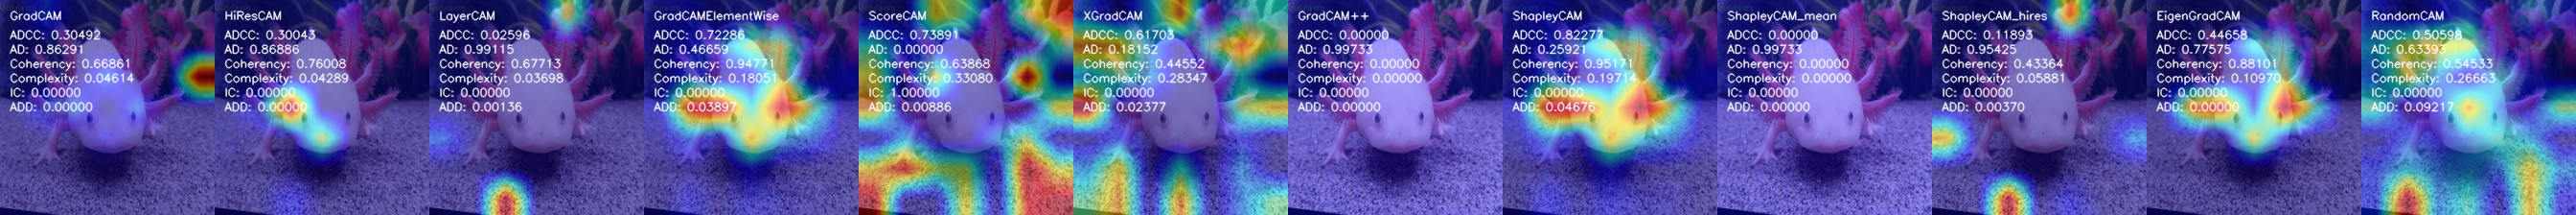

In [12]:
## mul
img_example = np.array(Image.open("./ILSVRC2012_val_00022113.JPEG")) 
category = 29 # 	tench


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:05<00:00, 12.03it/s]


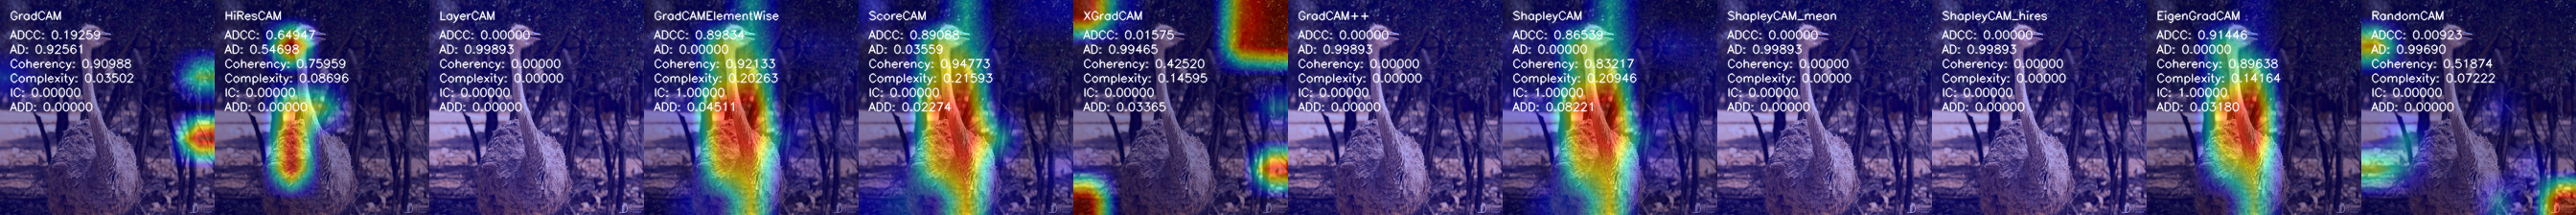

In [13]:
## mul
img_example = np.array(Image.open("./ILSVRC2012_val_00019184.JPEG")) 
category = 9 # ostrich


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:05<00:00, 11.29it/s]


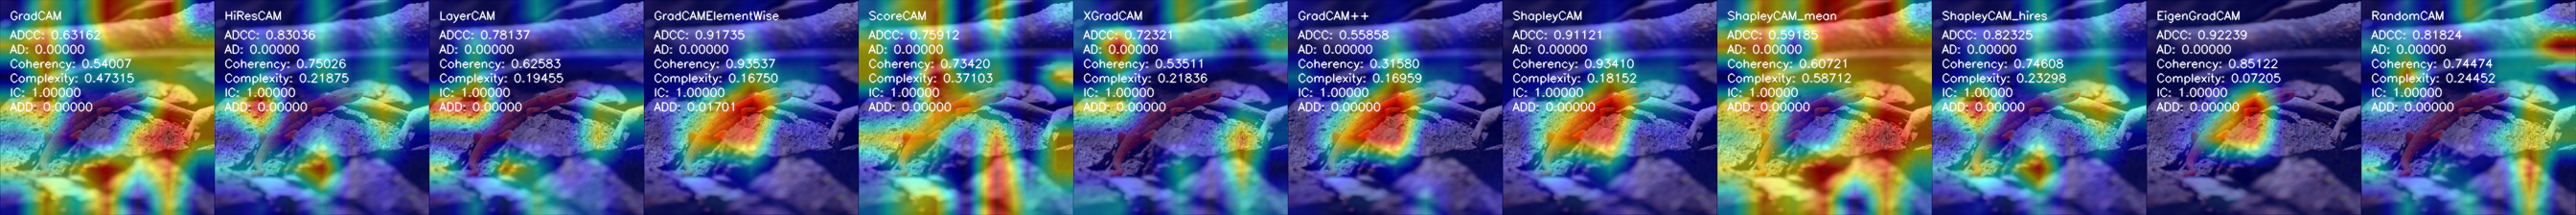

In [14]:
## mul
img_example = np.array(Image.open("./ILSVRC2012_val_00006149.JPEG")) 
category = 28 # spotted salamander


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:05<00:00, 10.87it/s]


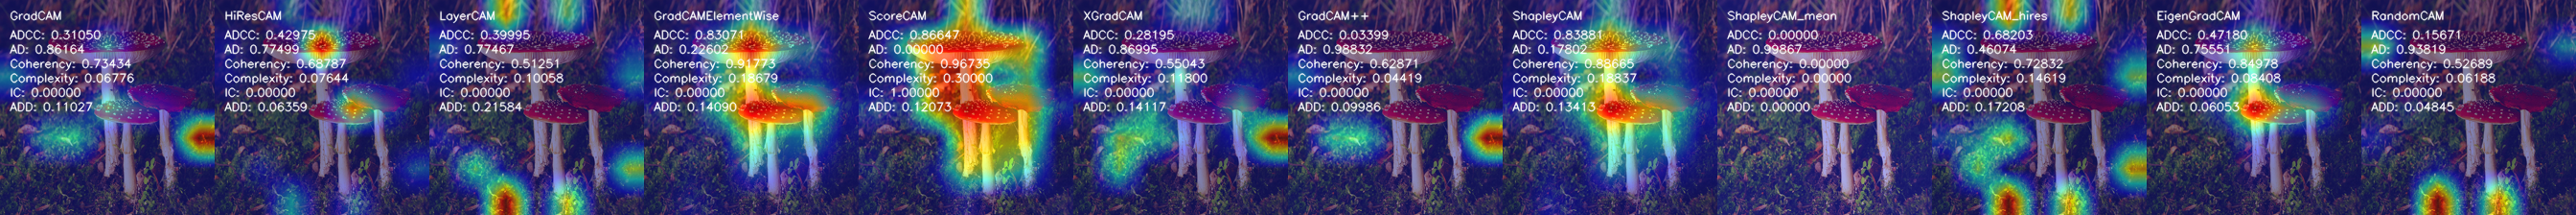

In [15]:
## mul
img_example = np.array(Image.open("./ILSVRC2012_val_00005745.JPEG")) # 992
category = 992 # agaric


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:06<00:00, 10.16it/s]


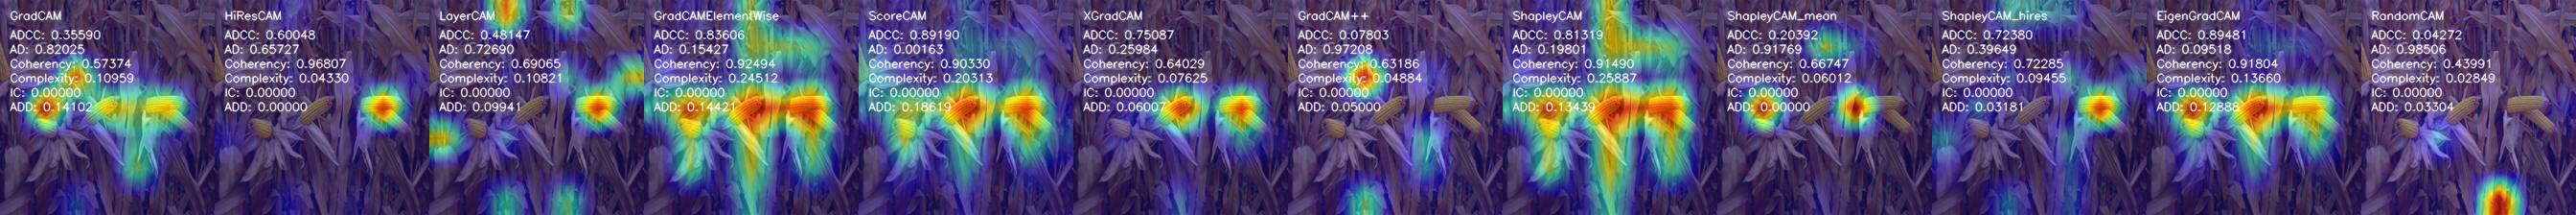

In [16]:
img_example = np.array(Image.open("./ILSVRC2012_val_00008440.JPEG")) 
category = 998 #spike


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:06<00:00,  9.92it/s]


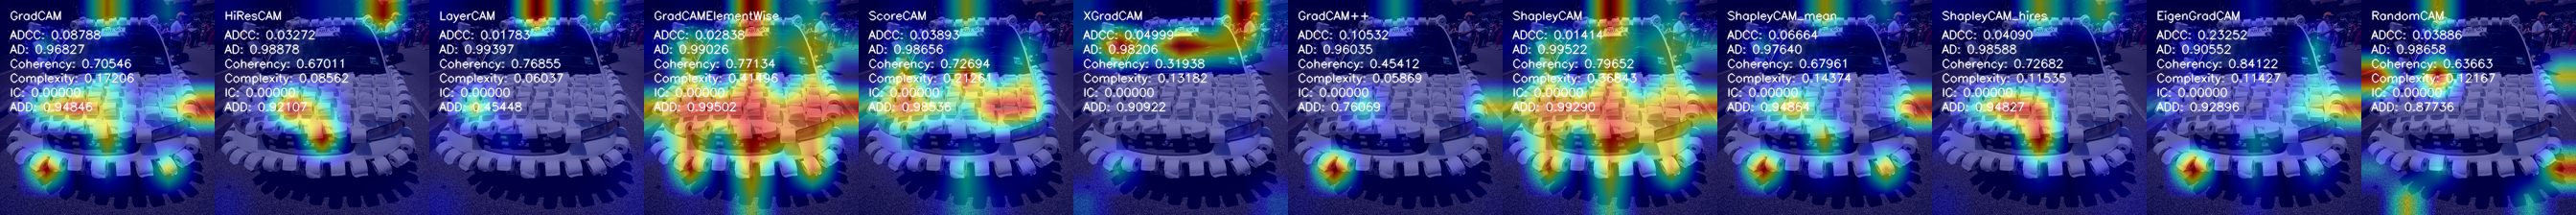

In [17]:
img_example = np.array(Image.open("./ILSVRC2012_val_00001079.JPEG")) 
category = 999 # toilet tissue


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:06<00:00,  9.39it/s]


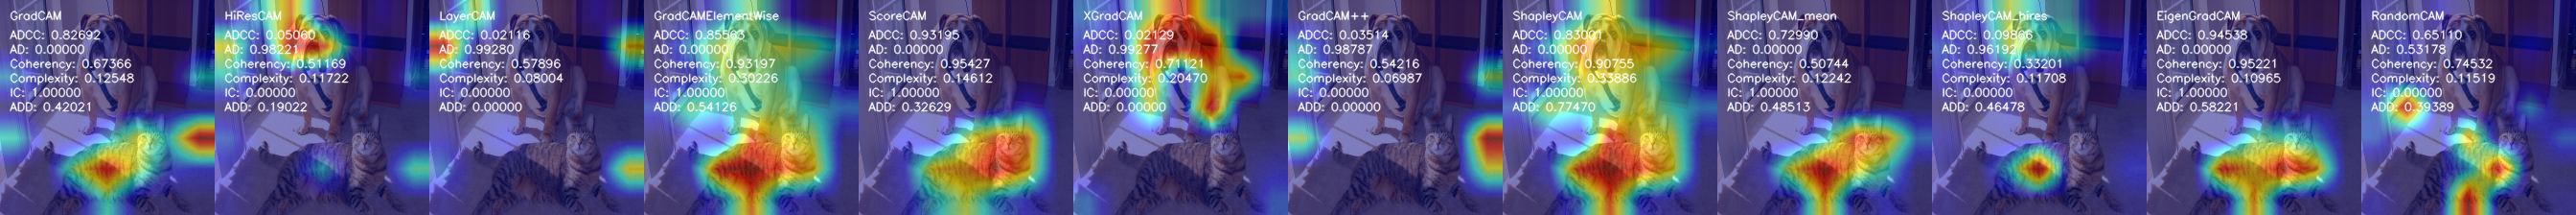

In [18]:


img_example = np.array(Image.open("../examples/both.png"))  
category = 281

 
img_example = np.float32(img_example) / 255

 
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

100%|██████████| 64/64 [00:07<00:00,  8.94it/s]


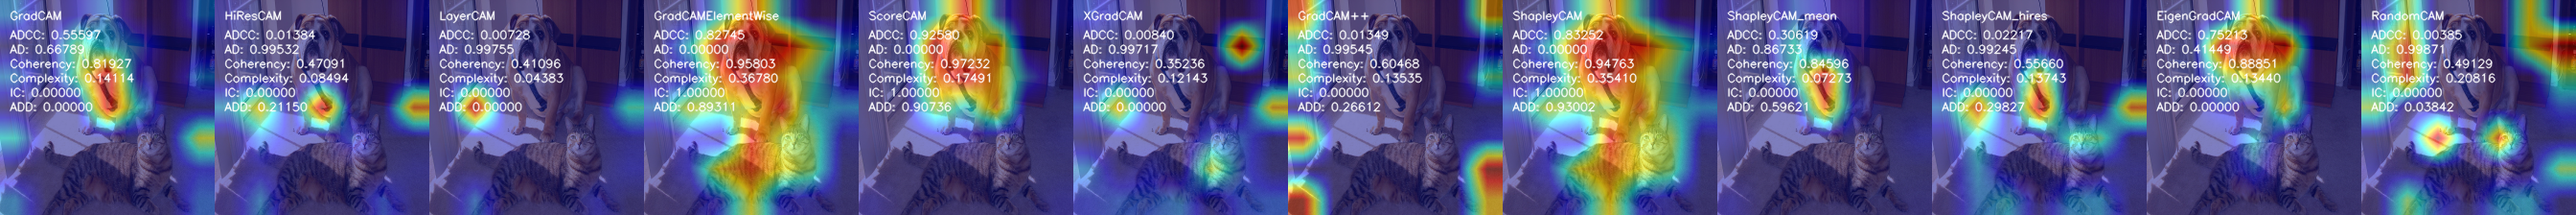

In [19]:
category = 243
# input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)